# Import modules and reduce memory usage

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import random
random.seed(100)
import warnings
warnings.filterwarnings("ignore")
# garbage collector to keep RAM in check
import gc 

# Load Dataset

In [47]:
df= pd.read_csv('train.csv')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


In [49]:
for i in df:
    if df[i].dtype == np.float64:
        if (((df[i] < .0001) & (df[i] > -.0001)).mean()) < .001:
            df[i] = df[i].astype(np.float32)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int64(3)
memory usage: 1.3 GB


# About Data

## Time series

Inspection about `date` and `ts_id` columns

In [51]:
num_days = len(np.unique(df["date"]))
print(f"Dataset has {num_days} days.")

Dataset has 500 days.


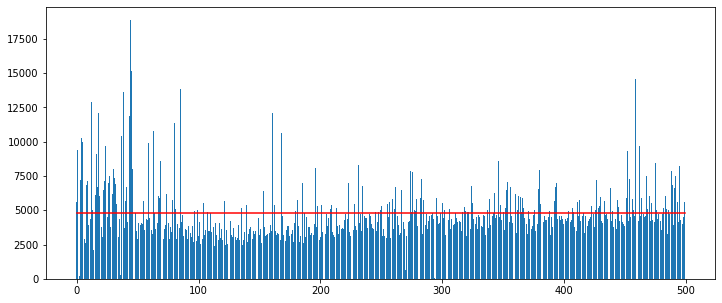

max time step : 18884
min time step : 29
mean time step : 4780.982
how much under the mean value : 64.60000000000001%


In [52]:
day_list = []
time_list= []
for i in range(500):
    day_list.append(i)
    time_list.append(len(df.query('date == {}'.format(i))))
time_list = np.array(time_list)
mean_val = sum(time_list)/len(time_list)

plt.figure(figsize = (12,5))
plt.bar(day_list, time_list)
plt.plot(day_list, [mean_val]*len(day_list), 'red')
plt.show()

print(f"max time step : {max(time_list)}")
print(f"min time step : {min(time_list)}")
print(f"mean time step : {mean_val}")
print(f"how much under the mean value : {len(time_list[time_list<mean_val])/len(time_list)*100}%")
del day_list
del time_list
gc.collect();

## Weight

how important

In [53]:
weight = df["weight"]
num_negative_weight = int(df[weight<0].sum().sum())
print(f"There is {num_negative_weight} negative weights.")

There is 0 negative weights.


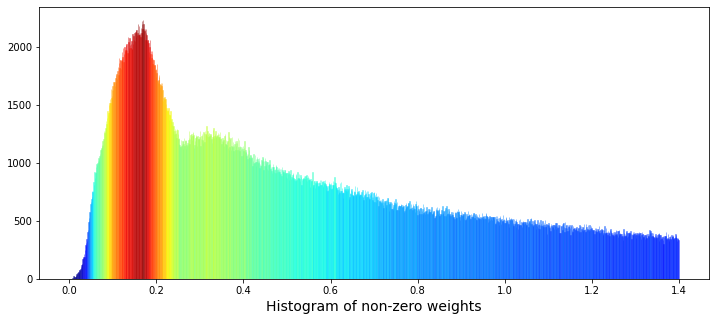

In [54]:
plt.figure(figsize = (12,5))
ax = sns.distplot(weight, 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values; del norm; del colors;
gc.collect();

## Resp

important

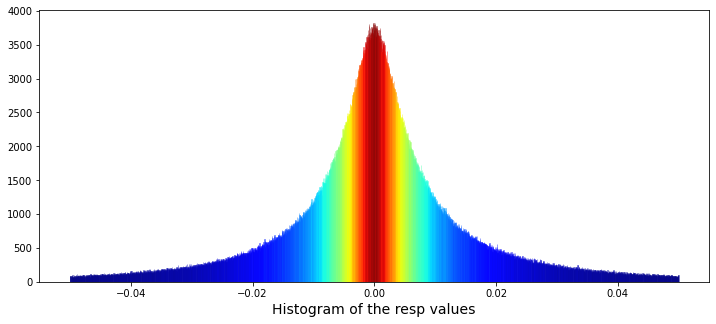

In [55]:
resp = df["resp"]

plt.figure(figsize = (12,5))
ax = sns.distplot(resp, 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
del values; del norm; del colors;
gc.collect();

explain

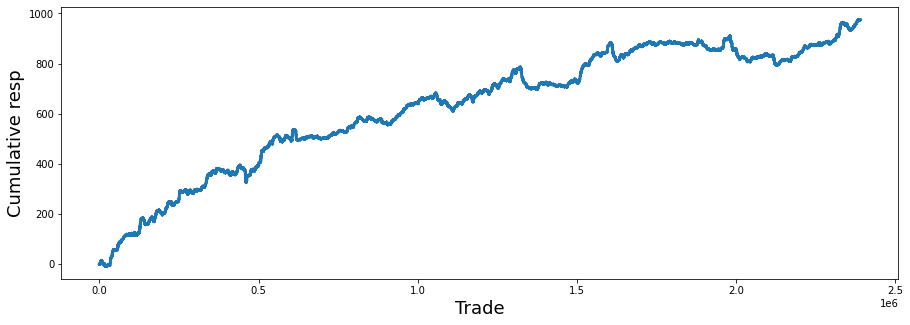

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(resp).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("Cumulative resp", fontsize=18);
balance.plot(lw=3);
del balance;
gc.collect();

## How can we make ACTION?

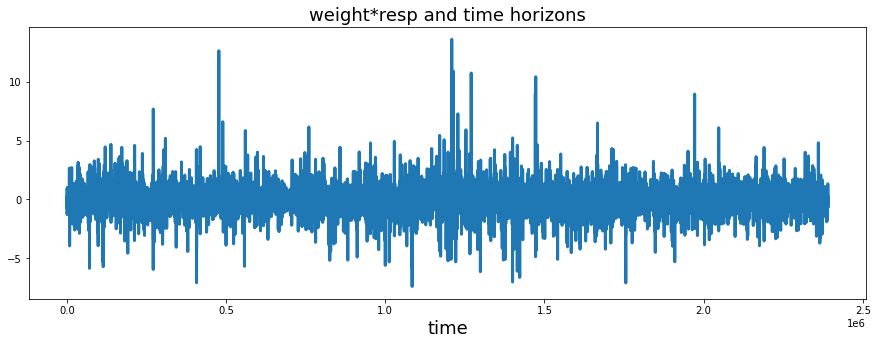

In [57]:
df['weight_resp'] = weight*resp

fig, ax = plt.subplots(figsize=(15, 5))
weight_resp = pd.Series(df['weight_resp'])

ax.set_xlabel ("time", fontsize=18)
ax.set_title ("weight*resp and time horizons", fontsize=18)
weight_resp.plot(lw=3, label='resp x weight')
del weight_resp;
gc.collect();

In [58]:
# 1 or 0
df["action"] = (df['weight_resp']>0).astype("int")

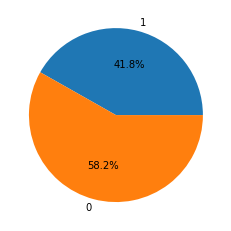

In [59]:
num_action1 = df["action"].sum()
num_action0 = len(df["action"])-df["action"].sum()
ratio = [num_action1, num_action0]
labels = ["1", "0"]
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

## Features

In [60]:
features = df.drop(columns=["date", "weight", "resp_1", "resp_2", "resp_3", "resp_4", "resp", "ts_id"])

In [61]:
features.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,weight_resp,action
0,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,...,1.168391,8.313582,1.782433,14.018213,2.653056,12.600291,2.301488,11.445807,0.000000,0
1,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,...,-1.178850,1.777472,-0.915459,2.831612,-1.417010,2.297459,-1.304614,1.898684,-0.163262,0


### Processing Null datas

In [62]:
features.isna().sum()>0

feature_0      False
feature_1      False
feature_2      False
feature_3       True
feature_4       True
               ...  
feature_127     True
feature_128     True
feature_129     True
weight_resp    False
action         False
Length: 132, dtype: bool

In [63]:
# more than 10% are empty
null_features = features.isnull().sum()
null_list = list(null_features[null_features >(0.10 * len(features))].index)
null_list

['feature_7',
 'feature_8',
 'feature_17',
 'feature_18',
 'feature_27',
 'feature_28',
 'feature_72',
 'feature_78',
 'feature_84',
 'feature_90',
 'feature_96',
 'feature_102',
 'feature_108',
 'feature_114']

In [64]:
df[['resp','weight']+null_list].corr().style.background_gradient(cmap='coolwarm')

,resp,weight,feature_7,feature_8,feature_17,feature_18,feature_27,feature_28,feature_72,feature_78,feature_84,feature_90,feature_96,feature_102,feature_108,feature_114
resp,1.000000,-0.006948,0.021207,0.014660,-0.028277,-0.017448,0.048293,0.032502,-0.002034,0.000072,0.011500,0.003604,0.013469,0.004613,0.013209,0.004385
weight,-0.006948,1.000000,-0.016164,-0.000819,-0.011541,-0.002568,-0.010643,0.001118,0.002058,0.000367,-0.041597,0.052486,-0.044057,0.056261,-0.046157,0.053893
feature_7,0.021207,-0.016164,1.000000,0.898832,0.402987,0.374951,0.487964,0.430844,-0.009719,-0.006903,-0.015400,-0.054359,-0.009083,-0.051083,-0.001724,-0.046770
feature_8,0.014660,-0.000819,0.898832,1.000000,0.373778,0.425576,0.424587,0.463257,-0.003916,0.001188,-0.002604,-0.038638,0.000781,-0.039802,0.010609,-0.034254
feature_17,-0.028277,-0.011541,0.402987,0.373778,1.000000,0.906956,-0.501928,-0.464884,-0.070201,-0.069432,-0.021351,-0.053571,0.039123,0.007819,0.016894,-0.020790
feature_18,-0.017448,-0.002568,0.374951,0.425576,0.906956,1.000000,-0.446295,-0.503707,-0.078615,-0.074634,-0.021682,-0.054821,0.040938,0.006212,0.017579,-0.023075
feature_27,0.048293,-0.010643,0.487964,0.424587,-0.501928,-0.446295,1.000000,0.900539,0.059322,0.060716,0.020922,-0.004243,-0.029925,-0.059175,0.000032,-0.028572
feature_28,0.032502,0.001118,0.430844,0.463257,-0.464884,-0.503707,0.900539,1.000000,0.074591,0.075029,0.030016,0.005652,-0.027775,-0.055675,0.006896,-0.021918
feature_72,-0.002034,0.002058,-0.009719,-0.003916,-0.070201,-0.078615,0.059322,0.074591,1.000000,0.773391,0.268906,0.209429,-0.208541,-0.144612,0.029765,0.032632
feature_78,0.000072,0.000367,-0.006903,0.001188,-0.069432,-0.074634,0.060716,0.075029,0.773391,1.000000,0.221750,0.234574,-0.149852,-0.183428,0.035854,0.024444


they don't have strong correlation with resp

### Drop the null columns

In [65]:
features.drop(columns=null_list,inplace=True)

### Fill the rest by mean values

In [66]:
features.fillna(features.mean(axis=0),inplace=True)

So, there is result features

In [67]:
features.head(3)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_9,feature_10,feature_11,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,weight_resp,action
0,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,-0.989982,-1.055090,0.089122,...,1.168391,8.313582,1.782433,14.018213,2.653056,12.600291,2.301488,11.445807,0.000000,0
1,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,-0.151877,-0.384952,0.089122,...,-1.178850,1.777472,-0.915459,2.831612,-1.417010,2.297459,-1.304614,1.898684,-0.163262,0
2,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,5.448261,2.668029,0.089122,...,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0.000000,0


# Clustering

using KMeans

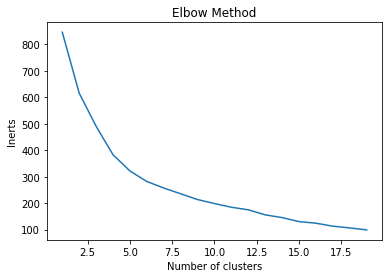

In [68]:
from sklearn.cluster import KMeans

features_columns = features.columns
corr = features.corr()
corr_np = corr.to_numpy()

inerts = []
max_clusters = 20
for i in range(1, max_clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=200, n_init=10, random_state=0)
    kmeans.fit(corr_np)
    inerts.append(kmeans.inertia_)
    
plt.plot(range(1, max_clusters), inerts)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inerts')
plt.show()

So We chose the number of clusters as 5.

In [69]:
n_clust = 5
kmeans = KMeans(n_clusters = n_clust, init = 'k-means++', max_iter = 200, n_init = 10, random_state = 0)
corr_labels = kmeans.fit_predict(corr_np)

corr_df = pd.DataFrame(np.c_[features_columns, corr_labels])
corr_df.columns = ["feature", "cluster"]
corr_df['feat_list'] = corr_df.groupby(["cluster"]).transform(lambda x: ', '.join(x))
corr_df = corr_df.groupby(["cluster", "feat_list"]).size().reset_index(name = 'feat_count')
corr_df

,cluster,feat_list,feat_count
0,0,"feature_0, feature_19, feature_20, feature_21,...",15
1,1,"feature_3, feature_4, feature_5, feature_6, fe...",35
2,2,"feature_1, feature_2, feature_9, feature_10, f...",24
3,3,"feature_44, feature_45, feature_86, feature_87...",22
4,4,"feature_29, feature_30, feature_31, feature_32...",22


In [70]:
print(corr_df['feat_list'][0])
print(corr_df['feat_count'][0])
print(corr_df['feat_list'][1])
print(corr_df['feat_count'][1])
print(corr_df['feat_list'][2])
print(corr_df['feat_count'][2])
print(corr_df['feat_list'][3])
print(corr_df['feat_count'][3])
print(corr_df['feat_list'][4])
print(corr_df['feat_count'][4])

feature_0, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_37, feature_38, feature_97, feature_100, feature_103, feature_106
15
feature_3, feature_4, feature_5, feature_6, feature_41, feature_46, feature_49, feature_50, feature_51, feature_52, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, feature_68, feature_70, feature_77, feature_83, feature_121, feature_123, feature_125, feature_127, feature_129, weight_resp, action
35
feature_1, feature_2, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_42, feature_43, feature_47, feature_48, feature_53, feature_69, feature_71, feature_109, feature_112, feature_120, feature_122, feature_124, feature_126, feature_128
24
feature_44, feature_45, feature_86, feature_87, feature_89, feature_92, feature_93, feature_95, featur

In [71]:
features_group0 = features.loc[:,[i.strip() for i in corr_df['feat_list'][0].split(",")]]
features_group1 = features.loc[:,[i.strip() for i in corr_df['feat_list'][1].split(",")]]
features_group2 = features.loc[:,[i.strip() for i in corr_df['feat_list'][2].split(",")]]
features_group3 = features.loc[:,[i.strip() for i in corr_df['feat_list'][3].split(",")]]
features_group4 = features.loc[:,[i.strip() for i in corr_df['feat_list'][4].split(",")]]

# PCA by group

In [72]:
from sklearn.decomposition import PCA
pca0 =  PCA(10).fit(features_group0) #15 -> 10
pca1 =  PCA(20).fit(features_group1) #35 -> 20
pca2 =  PCA(10).fit(features_group2) #24 -> 10
pca3 =  PCA(10).fit(features_group3) #22 -> 10
pca4 =  PCA(10).fit(features_group4) #22 -> 10

In [73]:
pca0.transform(features_group0)
pca1.transform(features_group1)
pca2.transform(features_group2)
pca3.transform(features_group3)
pca4.transform(features_group4)

df_pca_features0 = pd.DataFrame(pca0.transform(features_group0))
df_pca_features1 = pd.DataFrame(pca1.transform(features_group1))
df_pca_features2 = pd.DataFrame(pca2.transform(features_group2))
df_pca_features3 = pd.DataFrame(pca3.transform(features_group3))
df_pca_features4 = pd.DataFrame(pca4.transform(features_group4))

In [74]:
df_pca_features0.columns = ['pc'+str(i+1) for i in range(10)]
df_pca_features1.columns = ['pc'+str(i+1) for i in range(10,30)]
df_pca_features2.columns = ['pc'+str(i+1) for i in range(30,40)]
df_pca_features3.columns = ['pc'+str(i+1) for i in range(40,50)]
df_pca_features4.columns = ['pc'+str(i+1) for i in range(50,60)]

df_pca_features = pd.concat([df_pca_features0,df_pca_features1,df_pca_features2,df_pca_features3,df_pca_features4],axis=1)

In [75]:
df_pca_features.head(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,3.187347,2.073375,0.448554,2.994205,-1.744422,-0.095197,-0.055682,0.085600,0.562233,-0.080515,...,-1.068486,6.876144,0.462827,3.845700,-0.246491,1.217055,2.036718,3.161474,0.355711,3.370786
1,-1.605976,1.136638,1.315190,0.983926,0.689342,0.126721,0.070435,-0.286656,-0.503036,0.239725,...,2.576787,-1.934489,-0.649322,0.458724,-1.778199,-0.661759,-1.095249,0.292576,0.072613,0.906519
2,-1.479775,3.370545,1.504046,0.280504,1.633091,0.278381,-0.637683,-0.453061,-0.511445,0.125618,...,6.760232,-4.926034,0.549009,-1.076440,-4.417380,-0.989865,-4.297344,0.301696,-0.427799,0.394419


그리고 새로운 피쳐들과 weight, resp간의 correlation들을 알아보았습니다.

In [76]:
df_pca_features['weight'] = df.weight.values
df_pca_features['resp'] = df.resp.values
df_pca_features.corr().style.background_gradient(cmap='coolwarm')

In [77]:
df_pca_features.drop(columns=["weight", "resp"],inplace=True)

Clean up before the modeling

In [78]:
del df_pca_features0; del df_pca_features1; del df_pca_features2; del df_pca_features3; del df_pca_features4; 
del corr_np; del corr_labels; del PCA; del pca0; del pca1; del pca2; del pca3; del pca4;
del features_group0; del features_group1; del features_group2; del features_group3; del features_group4; 
del null_features; del null_list; del num_action0; del num_action1;
del corr; del corr_df; del features;

gc.collect();

# Modeling MLP
- input : PCA 피쳐들(60)을 가진 데이터
    - 2390491 = 4:1 = 1912391:478100
    - train:val:test = 80:10:10 split
    - train, val -> training
    - test -> score
- output : action

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Make dataset for training
Make dataset for MLP model using 60 PCA features and action
- X : 60 PCA features
- y : action
- train:test = 80:20

In [80]:
data = pd.concat([df["action"],df_pca_features], axis=1)

In [81]:
data.shape

(2390491, 61)

In [82]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=69)

Scaling data using `StandardScaler()` and make Customdata set using pytorch utils

In [83]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train.to_numpy()))
test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test.to_numpy()))

In [90]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

Make simple `binaryClassification` model using `nn.Module`

In [91]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(60, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Define model setting parameters and optimizer

In [93]:
EPOCHS = 10
LEARNING_RATE = 0.001

In [94]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=60, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Define accuracy 

In [95]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
y_pred_list = []
model.eval()

with torch.no_grad():
    for X_batch, y in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

In [ ]:
print(classification_report(y_test, y_pred_list))

# Conclusion & Future work
## Conclusion
-
-
-

## Future work
- Use `feature.csv`, which is metadata telling about features' characteristics
- Try another Clustering methods
- Try changing the hyperparameters of MLP
- Another Solutions : RNN(LSTM), Reinforcement Learning